# Modeling with Text Features

In this notebook we train and evaluate our previous deep learning model for the Wells Fargo stock price time series, except with modifications made to include the 8-K form time series for each of the 4 banks as input features as well. Similarly, the notebook can be broken up into 3 different parts: Model Architecture, Unit Testing Model, and Model Evaluation, with each part performing the same function as before.

## Model Architecture:

Revisiting the main goal of this project, suggests that the loss function for our modified model should be mean squared error as well, since our goals have not changed. In the code below we define and print a graph of our modified model architecture as well as justify the modifications.

In [1]:
# Loading Data's Vocabulary

import os
import json

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')

# Loading Training Dataset's Vocabulary
with open(os.path.join(path_to_data, 'vocab_8k_norm_train_WFC_JPM_BAC_C.json'), 'r') as f:
    vocab = json.load(f)

In [2]:
import os
import tensorflow as tf

def gen_print_model_stats(model, path):
    m = model()
    if not os.path.exists(os.path.join(path, model.__name__)):
        os.makedirs(os.path.join(path, model.__name__))
    fname = os.path.join(path, model.__name__, model.__name__)
    tf.keras.utils.plot_model(m, fname + '.png', show_shapes=True, expand_nested=True)
    tf.keras.backend.clear_session()
    return m.summary()

In [3]:
import os
import json
import pickle 
import tensorflow as tf

def embedding_matrix(vocab, init, emb_name):
    '''
    Constructs the embedding matrix for specific init type for a pre-initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = os.path.join('~', '.stockanalysis', 'model_resources', 'glove')
        glove_dir = os.path.expanduser(glove_dir)
        
        try:
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            config_path = os.expanduser(os.path.join('~', '.stockanalysis', 'config.json'))
            with open(config_path, 'r') as f:
                configuration = json.load(f)
            glove_vec_file = os.path.expanduser(configuration['Model_Resources']['glove'])
            # Building word to vector map
            word_embeddings = {}
            with open(glove_vec_file, 'r') as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, emb_name,
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init, emb_name)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab, emb_name, doc_embedding_size):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', emb_name=emb_name, mask_zero=False, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_text(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100, emb_name='current_embedding', 
               output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias = output_bias_init['adjusted_close_target_WFC']
        output_bias_init = tf.keras.initializers.Constant(output_bias)
        
    inputs = {
              'adjusted_close_WFC': tf.keras.Input(shape=(5,), name='adjusted_close_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'adjusted_close_JPM': tf.keras.Input(shape=(5,), name='adjusted_close_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'adjusted_close_BAC': tf.keras.Input(shape=(5,), name='adjusted_close_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'adjusted_close_C': tf.keras.Input(shape=(5,), name='adjusted_close_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64),
             }
    
    doc_embedder = document_embedder_model(vocab, emb_name, doc_embedding_size)
    document_embeddings = [doc_embedder(inputs[fname]) for fname in inputs.keys() if '8-k' in fname]
    
    reshape_doc_embedding = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))
    reshaped_doc_embeddings = [reshape_doc_embedding(doc_embedding) for doc_embedding in document_embeddings]
    
    reshape_price_feature = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))
    reshaped_price_features = [reshape_price_feature(inputs[fname]) for fname in inputs.keys() if '8-k' not in fname]
    time_series_input = tf.keras.layers.Concatenate()(reshaped_doc_embeddings + reshaped_price_features)
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='adjusted_close_target_WFC')
    outputs = {'adjusted_close_target_WFC': output_layer(time_series_lstm)}
    
    
    model = tf.keras.Model(inputs, outputs, name='model_text')
    
    return model

In [4]:
import os

gen_print_model_stats(model_text, os.path.join('logs', 'models'))

Model: "model_text"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
8-k_WFC (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
8-k_JPM (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
8-k_BAC (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
8-k_C (InputLayer)              [(None, None)]       0                                            
_________________________________________________________________________________________

Graph of Model:

<a title="Model Graph" href="logs/models/model_text/model_text.png"><img width="5000" src="logs/models/model_text/model_text.png"></a>

The above graph is a visual depiction of our chosen model architecture. It shows that the input features to our model have been decided to be the lagged 5 days stock prices for each of the stock tickers: WFC, JPM, BAC, and C. Again, this decision was made because these 4 banks are all major competitors with each other, and thus their stock prices should have some correlations baked into their time series. The core of our model architecture is the LSTM (long-short term memory) layer that we feed the stock price time series too. LSTM layers are a type of RNN (recurrent neural network) layer. RNNs are good a learning sequential dependences between data because the network contains inbuilt feedback between its inputs and outputs. This makes RNNs a natural choice when modeling stock price time series because the sequence in which prices occur in time is important to the problem of price prediction. LSTMs are an RNN layer that is specifically designed to learn long-term dependences easier than vanilla RNNs and avoid the vanishing gradient problem. Its because of these reasons that we chose to use an LSTM layer as the core of our time series model. 

(WEAERRAERA EDFADSSFADF)



***

## Unit Testing Model

Like the Unit Testing Model section in the previous notebook, we plan on running our new model through the same 3 tests before moving to the training and evaluation stage. The first test examines if our model can be initialized to be equivalent to the baseline model. The second, tests whether our dataset can be used to train models on. And the third, tests whether our model can overtrain on a small sample set of our dataset.

### 1. Testing if when initialized properly, the model is equivalent to the baseline model.

Restart kernel in order to fully clear GPU memory.

In [1]:
# Configuring Virtual GPU and Loading Data

import os
import json
import pickle

from stockanalysis.train import config_hardware

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')

# Random Seed
seed = 42

# Configuring GPU and TensorFlow
config_hardware(gpu_memory=3000, seed=seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)
    
# Loading Train Dataset's Vocabulary
with open(os.path.join(path_to_data, 'vocab_8k_norm_train_WFC_JPM_BAC_C.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
import tensorflow as tf

from sklearn.model_selection import train_test_split

def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

def baseline_model(output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias = output_bias_init['adjusted_close_target_WFC']
        output_bias_init = tf.keras.initializers.Constant(output_bias)
        
    inputs = {
              'adjusted_close_WFC': tf.keras.Input(shape=(5,), name='adjusted_close_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'adjusted_close_JPM': tf.keras.Input(shape=(5,), name='adjusted_close_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'adjusted_close_BAC': tf.keras.Input(shape=(5,), name='adjusted_close_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'adjusted_close_C': tf.keras.Input(shape=(5,), name='adjusted_close_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64)
             }
    
    features = tf.keras.layers.Concatenate()([inputs[fname] for fname in inputs.keys() if '8-k' not in fname])
    
    output_layer = tf.keras.layers.Dense(1, kernel_initializer='zeros', bias_initializer=output_bias_init, 
                                         name='adjusted_close_target_WFC')
    
    outputs = {
               'adjusted_close_target_WFC': output_layer(features)
              }
    
    model = tf.keras.Model(inputs, outputs, name='baseline_model')
    
    return model

Defining model.

In [3]:
import os
import json
import pickle 
import tensorflow as tf

def embedding_matrix(vocab, init, emb_name):
    '''
    Constructs the embedding matrix for specific init type for a pre-initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = os.path.join('~', '.stockanalysis', 'model_resources', 'glove')
        glove_dir = os.path.expanduser(glove_dir)
        
        try:
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            config_path = os.expanduser(os.path.join('~', '.stockanalysis', 'config.json'))
            with open(config_path, 'r') as f:
                configuration = json.load(f)
            glove_vec_file = os.path.expanduser(configuration['Model_Resources']['glove'])
            # Building word to vector map
            word_embeddings = {}
            with open(glove_vec_file, 'r') as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, emb_name,
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init, emb_name)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab, emb_name, doc_embedding_size):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', emb_name=emb_name, mask_zero=False, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_text(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100, emb_name='current_embedding', 
               output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias = output_bias_init['adjusted_close_target_WFC']
        output_bias_init = tf.keras.initializers.Constant(output_bias)
        
    inputs = {
              'adjusted_close_WFC': tf.keras.Input(shape=(5,), name='adjusted_close_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'adjusted_close_JPM': tf.keras.Input(shape=(5,), name='adjusted_close_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'adjusted_close_BAC': tf.keras.Input(shape=(5,), name='adjusted_close_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'adjusted_close_C': tf.keras.Input(shape=(5,), name='adjusted_close_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64),
             }
    
    doc_embedder = document_embedder_model(vocab, emb_name, doc_embedding_size)
    document_embeddings = [doc_embedder(inputs[fname]) for fname in inputs.keys() if '8-k' in fname]
    
    reshape_doc_embedding = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))
    reshaped_doc_embeddings = [reshape_doc_embedding(doc_embedding) for doc_embedding in document_embeddings]
    
    reshape_price_feature = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))
    reshaped_price_features = [reshape_price_feature(inputs[fname]) for fname in inputs.keys() if '8-k' not in fname]
    time_series_input = tf.keras.layers.Concatenate()(reshaped_doc_embeddings + reshaped_price_features)
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='adjusted_close_target_WFC')
    outputs = {'adjusted_close_target_WFC': output_layer(time_series_lstm)}
    
    
    model = tf.keras.Model(inputs, outputs, name='model_text')
    
    return model

Testing baseline equivalence of model when initialized properly.

In [4]:
import tensorflow as tf

from stockanalysis.train import build_compiled_model

def test_baseline_equivalence(model, baseline_model, batch_size, X, y):
    '''
    Tests baseline equivalence with baseline
    '''
    
    print('Testing if the untrained model when initialized properly is equivalent to the baseline model')
    
    output_bias_init = {key: y[key].mean() for key in y}
    
    loss = tf.keras.losses.MeanSquaredError
    
    hyperparameters_b = {
                         'model_parameters': {'output_bias_init': output_bias_init}, 
                         'training_parameters': {},
                         'loss': loss, 
                         'optimizer': tf.keras.optimizers.Adam, 
                         'optimizer_parameters': {},
                         'version': None
                        }
    
    baseline_m, initial_epoch = build_compiled_model(baseline_model, hyperparameters_b, metrics=[], run_number=None)
    baseline_results = baseline_m.evaluate(X, y, batch_size=batch_size, verbose=0)
    
    model_params = {'output_kernel_init': 'zeros', 'output_bias_init': output_bias_init}
    
    hyperparameters = {
                       'model_parameters': model_params, 
                       'training_parameters': {},
                       'loss': loss, 
                       'optimizer': tf.keras.optimizers.Adam, 
                       'optimizer_parameters': {}, 
                       'version': None
                      }
    
    m1, initial_epoch = build_compiled_model(model, hyperparameters, metrics=[], run_number=None)
    m1_results = m1.evaluate(X, y, batch_size=batch_size, verbose=0)
    
    assert m1_results == baseline_results
    
    return print('Passed')

In [5]:
X, y = sample_dataset(train_dataset, sample_size=16, seed=seed)
test_baseline_equivalence(model_text, baseline_model, batch_size=4, X=X, y=y)

Testing if the untrained model when initialized properly is equivalent to the baseline model
Passed


### 2. Testing if the model trained on real data performs better than the model trained on null data.

#### Using Null Data.

Restart kernel to clear GPU memory.

In [1]:
# Configuring Virtual GPU and Loading Data

import os
import json
import pickle

from stockanalysis.train import config_hardware

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')

# Random Seed
seed = 42

# Configuring GPU and TensorFlow
config_hardware(gpu_memory=7000, seed=seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Train Dataset's Vocabulary
with open(os.path.join(path_to_data, 'vocab_8k_norm_train_WFC_JPM_BAC_C.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
import numpy as np

from sklearn.model_selection import train_test_split

def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

def null_feature(feature_name, feature):
    if 'adjusted_close' in feature_name:
        null_feature = np.zeros(shape=feature.shape, dtype=feature.dtype)
    elif '8-k' in feature_name:
        null_feature = np.ones(shape=feature.shape, dtype=feature.dtype)
    return null_feature

def null_features(features):
    return {fname: null_feature(fname, features[fname]) for fname in features.keys()}

Defining model.

In [3]:
import os
import json
import pickle 
import tensorflow as tf

def embedding_matrix(vocab, init, emb_name):
    '''
    Constructs the embedding matrix for specific init type for a pre-initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = os.path.join('~', '.stockanalysis', 'model_resources', 'glove')
        glove_dir = os.path.expanduser(glove_dir)
        
        try:
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            config_path = os.expanduser(os.path.join('~', '.stockanalysis', 'config.json'))
            with open(config_path, 'r') as f:
                configuration = json.load(f)
            glove_vec_file = os.path.expanduser(configuration['Model_Resources']['glove'])
            # Building word to vector map
            word_embeddings = {}
            with open(glove_vec_file, 'r') as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, emb_name,
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init, emb_name)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab, emb_name, doc_embedding_size):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', emb_name=emb_name, mask_zero=False, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_text(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100, emb_name='current_embedding', 
               output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias = output_bias_init['adjusted_close_target_WFC']
        output_bias_init = tf.keras.initializers.Constant(output_bias)
        
    inputs = {
              'adjusted_close_WFC': tf.keras.Input(shape=(5,), name='adjusted_close_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'adjusted_close_JPM': tf.keras.Input(shape=(5,), name='adjusted_close_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'adjusted_close_BAC': tf.keras.Input(shape=(5,), name='adjusted_close_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'adjusted_close_C': tf.keras.Input(shape=(5,), name='adjusted_close_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64),
             }
    
    doc_embedder = document_embedder_model(vocab, emb_name, doc_embedding_size)
    document_embeddings = [doc_embedder(inputs[fname]) for fname in inputs.keys() if '8-k' in fname]
    
    reshape_doc_embedding = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))
    reshaped_doc_embeddings = [reshape_doc_embedding(doc_embedding) for doc_embedding in document_embeddings]
    
    reshape_price_feature = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))
    reshaped_price_features = [reshape_price_feature(inputs[fname]) for fname in inputs.keys() if '8-k' not in fname]
    time_series_input = tf.keras.layers.Concatenate()(reshaped_doc_embeddings + reshaped_price_features)
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='adjusted_close_target_WFC')
    outputs = {'adjusted_close_target_WFC': output_layer(time_series_lstm)}
    
    
    model = tf.keras.Model(inputs, outputs, name='model_text')
    
    return model

Training model on null features.

In [6]:
import tensorflow as tf

from stockanalysis.train import train

# Sampling Data and Nulling Features
X, y = sample_dataset(train_dataset, sample_size=16, seed=seed)
X_null = null_features(X)

# Defining Hyperparameters
output_bias_init = {key: y[key].mean() for key in y}
model_params = {'output_bias_init': output_bias_init}
training_params = {'epochs': 30, 'batch_size': 6}

hyperparameters = {
                   'model_parameters': model_params, 
                   'training_parameters': training_params,
                   'loss': tf.keras.losses.MeanSquaredError,
                   'optimizer': tf.keras.optimizers.Adam, 
                   'optimizer_parameters': {}, 
                   'version': None
                  }

# Training Model
model, model_history = train(model_text, hyperparameters, metrics=[], run_number=None, X=X_null, y=y)

Train on 16 samples
Epoch 1/30
16/16 [==============================] - 21s 1s/sample - loss: 23.4841
Epoch 2/30
16/16 [==============================] - 19s 1s/sample - loss: 21.4231
Epoch 3/30
16/16 [==============================] - 19s 1s/sample - loss: 21.8424
Epoch 4/30
16/16 [==============================] - 18s 1s/sample - loss: 21.8074
Epoch 5/30
16/16 [==============================] - 23s 1s/sample - loss: 21.6725
Epoch 6/30
16/16 [==============================] - 23s 1s/sample - loss: 21.4724
Epoch 7/30
16/16 [==============================] - 29s 2s/sample - loss: 21.6153
Epoch 8/30
16/16 [==============================] - 26s 2s/sample - loss: 21.4916
Epoch 9/30
16/16 [==============================] - 23s 1s/sample - loss: 21.4825
Epoch 10/30
16/16 [==============================] - 24s 1s/sample - loss: 21.4765
Epoch 11/30
16/16 [==============================] - 9s 557ms/sample - loss: 21.4920
Epoch 12/30
16/16 [==============================] - 9s 569ms/sample - los

Evaluating model.

In [7]:
model_results = model.evaluate(X, y, batch_size=training_params['batch_size'], verbose=0)

In [8]:
print('Metrics for model trained on zeroed features.')
print()
print('Loss for Model: {}'.format(model_results))
print()

Metrics for model trained on zeroed features.

Loss for Model: 20.817207098007202



#### Using Real data.

Restart kernel to clear GPU memory.

In [1]:
# Configuring Virtual GPU and Loading Data

import os
import json
import pickle

from stockanalysis.train import config_hardware

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')

# Random Seed
seed = 42

# Configuring GPU and TensorFlow
config_hardware(gpu_memory=7000, seed=seed)


# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)
    
# Loading Train Dataset's Vocabulary
with open(os.path.join(path_to_data, 'vocab_8k_norm_train_WFC_JPM_BAC_C.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
from sklearn.model_selection import train_test_split

def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

Defining model.

In [3]:
import os
import json
import pickle 
import tensorflow as tf

def embedding_matrix(vocab, init, emb_name):
    '''
    Constructs the embedding matrix for specific init type for a pre-initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = os.path.join('~', '.stockanalysis', 'model_resources', 'glove')
        glove_dir = os.path.expanduser(glove_dir)
        
        try:
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            config_path = os.expanduser(os.path.join('~', '.stockanalysis', 'config.json'))
            with open(config_path, 'r') as f:
                configuration = json.load(f)
            glove_vec_file = os.path.expanduser(configuration['Model_Resources']['glove'])
            # Building word to vector map
            word_embeddings = {}
            with open(glove_vec_file, 'r') as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, emb_name,
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init, emb_name)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab, emb_name, doc_embedding_size):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', emb_name=emb_name, mask_zero=False, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_text(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100, emb_name='current_embedding', 
               output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias = output_bias_init['adjusted_close_target_WFC']
        output_bias_init = tf.keras.initializers.Constant(output_bias)
        
    inputs = {
              'adjusted_close_WFC': tf.keras.Input(shape=(5,), name='adjusted_close_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'adjusted_close_JPM': tf.keras.Input(shape=(5,), name='adjusted_close_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'adjusted_close_BAC': tf.keras.Input(shape=(5,), name='adjusted_close_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'adjusted_close_C': tf.keras.Input(shape=(5,), name='adjusted_close_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64),
             }
    
    doc_embedder = document_embedder_model(vocab, emb_name, doc_embedding_size)
    document_embeddings = [doc_embedder(inputs[fname]) for fname in inputs.keys() if '8-k' in fname]
    
    reshape_doc_embedding = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))
    reshaped_doc_embeddings = [reshape_doc_embedding(doc_embedding) for doc_embedding in document_embeddings]
    
    reshape_price_feature = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))
    reshaped_price_features = [reshape_price_feature(inputs[fname]) for fname in inputs.keys() if '8-k' not in fname]
    time_series_input = tf.keras.layers.Concatenate()(reshaped_doc_embeddings + reshaped_price_features)
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='adjusted_close_target_WFC')
    outputs = {'adjusted_close_target_WFC': output_layer(time_series_lstm)}
    
    
    model = tf.keras.Model(inputs, outputs, name='model_text')
    
    return model

Training model on actual data.

In [5]:
import tensorflow as tf

from stockanalysis.train import train

# Sampling Data
X, y = sample_dataset(train_dataset, sample_size=16, seed=seed)

# Defining Hyperparameters
output_bias_init = {key: y[key].mean() for key in y}
model_params = {'output_bias_init': output_bias_init}
training_params = {'epochs': 30, 'batch_size': 6}

hyperparameters = {
                   'model_parameters': model_params, 
                   'training_parameters': training_params,
                   'loss': tf.keras.losses.MeanSquaredError,
                   'optimizer': tf.keras.optimizers.Adam, 
                   'optimizer_parameters': {}, 
                   'version': None
                  }

# Training Model
model, model_history = train(model_text, hyperparameters, metrics=[], run_number=None, X=X, y=y)

Train on 16 samples
Epoch 1/30
16/16 [==============================] - 13s 828ms/sample - loss: 20.9907
Epoch 2/30
16/16 [==============================] - 9s 555ms/sample - loss: 20.4879
Epoch 3/30
16/16 [==============================] - 9s 552ms/sample - loss: 19.8153
Epoch 4/30
16/16 [==============================] - 9s 568ms/sample - loss: 18.8336
Epoch 5/30
16/16 [==============================] - 9s 563ms/sample - loss: 18.3563
Epoch 6/30
16/16 [==============================] - 9s 583ms/sample - loss: 18.5154
Epoch 7/30
16/16 [==============================] - 9s 577ms/sample - loss: 18.3728
Epoch 8/30
16/16 [==============================] - 9s 568ms/sample - loss: 17.9085
Epoch 9/30
16/16 [==============================] - 9s 579ms/sample - loss: 17.6864
Epoch 10/30
16/16 [==============================] - 9s 564ms/sample - loss: 17.3243
Epoch 11/30
16/16 [==============================] - 9s 585ms/sample - loss: 16.9998
Epoch 12/30
16/16 [==============================] - 

Evaluating model.

In [6]:
model_results = model.evaluate(X, y, batch_size=training_params['batch_size'], verbose=0)

In [7]:
print('Metrics for model trained on actual data.')
print()
print('Loss for Model: {}'.format(model_results))

Metrics for model trained on actual data.

Loss for Model: 9.051951050758362


Checks out. The model when trained on actual data has a smaller loss than when trained on the null features.

### 3. Testing if the model can overfit on a small sample of data.

Restart kernel to clear GPU memory.

In [1]:
# Configuring Virtual GPU and Loading Data

import os
import json
import pickle

from stockanalysis.train import config_hardware

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')

# Random Seed
seed = 42

# Configuring GPU and TensorFlow
config_hardware(gpu_memory=7000, seed=seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)
    
# Loading Train Dataset's Vocabulary
with open(os.path.join(path_to_data, 'vocab_8k_norm_train_WFC_JPM_BAC_C.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

def plot_errors(predictions, true_labels, title):
    fig, ax = plt.subplots()
    err = true_labels - predictions
    ax.plot(err, 'bo')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Error')
    ax.set_title(title)
    plt.show()
    return None

def plot_outputs_errors(predictions, true_labels, title):
    for i in range(len(true_labels.keys())):
        #print(list(range(len(true_labels.keys()))))
        label_name = list(true_labels.keys())[i]
        labels = true_labels[label_name]
        preds = predictions[:, i]
        assert len(preds) == len(labels)
        name = '_'.join([label_name, title]).replace("_"," ").capitalize()
        plot_errors(preds, labels, name)
    return None

def plot_ts_sample_ba(feature_value, target_value, prediction_b_value, prediction_a_value, ts_fname, sample_num):
    name = ts_fname.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(feature_value, '-b')
    ax.plot(len(feature_value), target_value, 'bo', label='True Value')
    ax.plot(len(feature_value), prediction_b_value, 'g+', label='Prediction Before Training')
    ax.plot(len(feature_value), prediction_a_value, 'rx', label='Prediction After Training')
    ax.set_xlabel('Timesteps')
    ax.set_ylabel(name)
    ax.set_title('Sample {}'.format(sample_num))
    ax.legend()
    plt.show()
    print('True Target Value: {}'.format(target_value))
    print('Predicted Target Value Before Training: {}'.format(prediction_b_value))
    print('Predicted Target Value After Training: {}'.format(prediction_a_value))
    print()
    print()
    return None

def plot_ts_samples_ba(features, targets, predictions_b, predictions_a, ts_fname):
    feature = features[ts_fname]
    name = ts_fname.split('_')
    ticker = name.pop()
    name = '_'.join(name)
    target = targets['_'.join([name, 'target', ticker])]
    prediction_b = None
    prediction_a = None
    for i in range(len(targets.keys())):
        target_name = list(targets.keys())[i]
        if target_name == '_'.join([name, 'target', ticker]):
            prediction_b = predictions_b[:, i]
            prediction_a = predictions_a[:, i]
    assert len(prediction_b) == len(prediction_a) == len(target) == len(feature)
    
    for i in range(len(target)):
        plot_ts_sample_ba(feature[i], target[i], prediction_b[i], prediction_a[i], ts_fname, i)
    return None
            
def plot_metric(history, metric):
    name = metric.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(history[metric], label='Train')
    if 'val_' + metric in history:
        ax.plot(history['val_' + metric], linestyle="--", label='Val')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(name)
    ax.set_title(name)
    ax.legend()
    plt.show()
    return None

Defining model.

In [3]:
import os
import json
import pickle 
import tensorflow as tf

def embedding_matrix(vocab, init, emb_name):
    '''
    Constructs the embedding matrix for specific init type for a pre-initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = os.path.join('~', '.stockanalysis', 'model_resources', 'glove')
        glove_dir = os.path.expanduser(glove_dir)
        
        try:
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            config_path = os.expanduser(os.path.join('~', '.stockanalysis', 'config.json'))
            with open(config_path, 'r') as f:
                configuration = json.load(f)
            glove_vec_file = os.path.expanduser(configuration['Model_Resources']['glove'])
            # Building word to vector map
            word_embeddings = {}
            with open(glove_vec_file, 'r') as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, emb_name,
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init, emb_name)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab, emb_name, doc_embedding_size):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', emb_name=emb_name, mask_zero=False, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_text(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100, emb_name='current_embedding', 
               output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias = output_bias_init['adjusted_close_target_WFC']
        output_bias_init = tf.keras.initializers.Constant(output_bias)
        
    inputs = {
              'adjusted_close_WFC': tf.keras.Input(shape=(5,), name='adjusted_close_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'adjusted_close_JPM': tf.keras.Input(shape=(5,), name='adjusted_close_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'adjusted_close_BAC': tf.keras.Input(shape=(5,), name='adjusted_close_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'adjusted_close_C': tf.keras.Input(shape=(5,), name='adjusted_close_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64),
             }
    
    doc_embedder = document_embedder_model(vocab, emb_name, doc_embedding_size)
    document_embeddings = [doc_embedder(inputs[fname]) for fname in inputs.keys() if '8-k' in fname]
    
    reshape_doc_embedding = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))
    reshaped_doc_embeddings = [reshape_doc_embedding(doc_embedding) for doc_embedding in document_embeddings]
    
    reshape_price_feature = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))
    reshaped_price_features = [reshape_price_feature(inputs[fname]) for fname in inputs.keys() if '8-k' not in fname]
    time_series_input = tf.keras.layers.Concatenate()(reshaped_doc_embeddings + reshaped_price_features)
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='adjusted_close_target_WFC')
    outputs = {'adjusted_close_target_WFC': output_layer(time_series_lstm)}
    
    
    model = tf.keras.Model(inputs, outputs, name='model_text')
    
    return model

Overtraining model on a small sample of the data.

In [4]:
import tensorflow as tf

from stockanalysis.train import build_compiled_model

def overfit_small_sample(model, batch_size, epochs, X_small, y_small, verbose):
    print('Testing if model can overfit on a small sample of data')
    
    # Defining Model Hyperparameters for Test
    output_bias_init = {key: y_small[key].mean() for key in y_small}
    model_params = {'output_bias_init': output_bias_init}
    training_params = {'epochs': epochs, 'batch_size': batch_size}
    hyperparameters = {
                       'model_parameters': model_params, 
                       'training_parameters': training_params,
                       'loss': tf.keras.losses.MeanSquaredError, 
                       'optimizer': tf.keras.optimizers.Adam,
                       'optimizer_parameters': {},
                       'version': None
                      }
    
    m, initial_epoch = build_compiled_model(model, hyperparameters, metrics=[], run_number=None)
    m_pred_untrained = m.predict(X_small, batch_size=batch_size)
    m_history = m.fit(X_small, y_small, **training_params, initial_epoch=initial_epoch, verbose=verbose)
    m_pred_trained = m.predict(X_small, batch_size=batch_size)
    
    print()
    print('Plotting Error against Sample for Before Training, and After Training on the Small Dataset')
    plot_outputs_errors(m_pred_untrained, y_small, 'Before Training')
    plot_outputs_errors(m_pred_trained, y_small, 'After Training')
    print()
    
    print('Plotting Each Sample\'s Time Series')
    plot_ts_samples_ba(X_small, y_small, m_pred_untrained, m_pred_trained, 'adjusted_close_WFC')
    
    metrics = m.metrics_names
    for met in metrics:
        plot_metric(m_history.history, metric=met)
        
    return None

Testing if model can overfit on a small sample of data
Train on 2 samples
Epoch 1/1000
2/2 [==============================] - 6s 3s/sample - loss: 21.4558
Epoch 2/1000
2/2 [==============================] - 3s 1s/sample - loss: 21.2582
Epoch 3/1000
2/2 [==============================] - 3s 1s/sample - loss: 19.2471
Epoch 4/1000
2/2 [==============================] - 3s 1s/sample - loss: 19.7620
Epoch 5/1000
2/2 [==============================] - 3s 1s/sample - loss: 19.5867
Epoch 6/1000
2/2 [==============================] - 3s 1s/sample - loss: 18.6758
Epoch 7/1000
2/2 [==============================] - 3s 1s/sample - loss: 18.6764
Epoch 8/1000
2/2 [==============================] - 3s 1s/sample - loss: 19.0391
Epoch 9/1000
2/2 [==============================] - 3s 1s/sample - loss: 18.4707
Epoch 10/1000
2/2 [==============================] - 3s 1s/sample - loss: 18.2191
Epoch 11/1000
2/2 [==============================] - 3s 1s/sample - loss: 18.3291
Epoch 12/1000
2/2 [==============

Epoch 101/1000
2/2 [==============================] - 3s 1s/sample - loss: 4.5059
Epoch 102/1000
2/2 [==============================] - 3s 1s/sample - loss: 4.4434
Epoch 103/1000
2/2 [==============================] - 3s 1s/sample - loss: 4.3815
Epoch 104/1000
2/2 [==============================] - 3s 1s/sample - loss: 4.3246
Epoch 105/1000
2/2 [==============================] - 3s 1s/sample - loss: 4.2693
Epoch 106/1000
2/2 [==============================] - 3s 1s/sample - loss: 4.2112
Epoch 107/1000
2/2 [==============================] - 3s 1s/sample - loss: 4.1527
Epoch 108/1000
2/2 [==============================] - 3s 1s/sample - loss: 4.0965
Epoch 109/1000
2/2 [==============================] - 3s 1s/sample - loss: 4.0401
Epoch 110/1000
2/2 [==============================] - 3s 1s/sample - loss: 3.9804
Epoch 111/1000
2/2 [==============================] - 3s 1s/sample - loss: 3.9232
Epoch 112/1000
2/2 [==============================] - 3s 1s/sample - loss: 3.8703
Epoch 113/1000
2

Epoch 201/1000
2/2 [==============================] - 3s 1s/sample - loss: 1.3062
Epoch 202/1000
2/2 [==============================] - 3s 1s/sample - loss: 1.2902
Epoch 203/1000
2/2 [==============================] - 3s 1s/sample - loss: 1.2744
Epoch 204/1000
2/2 [==============================] - 3s 1s/sample - loss: 1.2587
Epoch 205/1000
2/2 [==============================] - 3s 1s/sample - loss: 1.2432
Epoch 206/1000
2/2 [==============================] - 3s 1s/sample - loss: 1.2279
Epoch 207/1000
2/2 [==============================] - 3s 1s/sample - loss: 1.2128
Epoch 208/1000
2/2 [==============================] - 3s 1s/sample - loss: 1.1978
Epoch 209/1000
2/2 [==============================] - 3s 1s/sample - loss: 1.1830
Epoch 210/1000
2/2 [==============================] - 3s 1s/sample - loss: 1.1684
Epoch 211/1000
2/2 [==============================] - 3s 1s/sample - loss: 1.1539
Epoch 212/1000
2/2 [==============================] - 3s 1s/sample - loss: 1.1395
Epoch 213/1000
2

Epoch 301/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.3467
Epoch 302/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.3418
Epoch 303/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.3369
Epoch 304/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.3321
Epoch 305/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.3273
Epoch 306/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.3226
Epoch 307/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.3180
Epoch 308/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.3134
Epoch 309/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.3089
Epoch 310/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.3044
Epoch 311/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.3000
Epoch 312/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.2957
Epoch 313/1000
2

Epoch 401/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0730
Epoch 402/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0718
Epoch 403/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0706
Epoch 404/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0694
Epoch 405/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0683
Epoch 406/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0671
Epoch 407/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0660
Epoch 408/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0649
Epoch 409/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0638
Epoch 410/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0627
Epoch 411/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0616
Epoch 412/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0606
Epoch 413/1000
2

Epoch 501/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0119
Epoch 502/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0116
Epoch 503/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0114
Epoch 504/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0112
Epoch 505/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0110
Epoch 506/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0108
Epoch 507/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0105
Epoch 508/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0103
Epoch 509/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0101
Epoch 510/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0099
Epoch 511/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0097
Epoch 512/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0096
Epoch 513/1000
2

Epoch 601/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0015
Epoch 602/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0014
Epoch 603/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0014
Epoch 604/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0014
Epoch 605/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0013
Epoch 606/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0013
Epoch 607/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0013
Epoch 608/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0013
Epoch 609/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0012
Epoch 610/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0012
Epoch 611/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0012
Epoch 612/1000
2/2 [==============================] - 3s 1s/sample - loss: 0.0011
Epoch 613/1000
2

2/2 [==============================] - 3s 1s/sample - loss: 1.5204e-04
Epoch 698/1000
2/2 [==============================] - 3s 1s/sample - loss: 1.4832e-04
Epoch 699/1000
2/2 [==============================] - 3s 1s/sample - loss: 1.4466e-04
Epoch 700/1000
2/2 [==============================] - 3s 1s/sample - loss: 1.4108e-04
Epoch 701/1000
2/2 [==============================] - 3s 1s/sample - loss: 1.3758e-04
Epoch 702/1000
2/2 [==============================] - 3s 1s/sample - loss: 1.3416e-04
Epoch 703/1000
2/2 [==============================] - 3s 1s/sample - loss: 1.3085e-04
Epoch 704/1000
2/2 [==============================] - 3s 1s/sample - loss: 1.2757e-04
Epoch 705/1000
2/2 [==============================] - 3s 1s/sample - loss: 1.2440e-04
Epoch 706/1000
2/2 [==============================] - 3s 1s/sample - loss: 1.2130e-04
Epoch 707/1000
2/2 [==============================] - 3s 1s/sample - loss: 1.1829e-04
Epoch 708/1000
2/2 [==============================] - 3s 1s/sample - 

Epoch 793/1000
2/2 [==============================] - 3s 1s/sample - loss: 1.2098e-05
Epoch 794/1000
2/2 [==============================] - 3s 1s/sample - loss: 1.1756e-05
Epoch 795/1000
2/2 [==============================] - 3s 1s/sample - loss: 1.1436e-05
Epoch 796/1000
2/2 [==============================] - 3s 1s/sample - loss: 1.1119e-05
Epoch 797/1000
2/2 [==============================] - 3s 1s/sample - loss: 1.0809e-05
Epoch 798/1000
2/2 [==============================] - 3s 1s/sample - loss: 1.0512e-05
Epoch 799/1000
2/2 [==============================] - 3s 1s/sample - loss: 1.0219e-05
Epoch 800/1000
2/2 [==============================] - 3s 1s/sample - loss: 9.9370e-06
Epoch 801/1000
2/2 [==============================] - 3s 1s/sample - loss: 9.6605e-06
Epoch 802/1000
2/2 [==============================] - 3s 1s/sample - loss: 9.3878e-06
Epoch 803/1000
2/2 [==============================] - 3s 1s/sample - loss: 9.1349e-06
Epoch 804/1000
2/2 [==============================] - 

Epoch 889/1000
2/2 [==============================] - 3s 1s/sample - loss: 7.3124e-07
Epoch 890/1000
2/2 [==============================] - 3s 1s/sample - loss: 7.0792e-07
Epoch 891/1000
2/2 [==============================] - 3s 1s/sample - loss: 6.8716e-07
Epoch 892/1000
2/2 [==============================] - 3s 1s/sample - loss: 6.6619e-07
Epoch 893/1000
2/2 [==============================] - 3s 1s/sample - loss: 6.4394e-07
Epoch 894/1000
2/2 [==============================] - 3s 1s/sample - loss: 6.2622e-07
Epoch 895/1000
2/2 [==============================] - 3s 1s/sample - loss: 6.0417e-07
Epoch 896/1000
2/2 [==============================] - 3s 1s/sample - loss: 5.8748e-07
Epoch 897/1000
2/2 [==============================] - 3s 1s/sample - loss: 5.6857e-07
Epoch 898/1000
2/2 [==============================] - 3s 1s/sample - loss: 5.4998e-07
Epoch 899/1000
2/2 [==============================] - 3s 1s/sample - loss: 5.3361e-07
Epoch 900/1000
2/2 [==============================] - 

Epoch 985/1000
2/2 [==============================] - 3s 1s/sample - loss: 3.7007e-08
Epoch 986/1000
2/2 [==============================] - 3s 1s/sample - loss: 3.6003e-08
Epoch 987/1000
2/2 [==============================] - 3s 1s/sample - loss: 3.4410e-08
Epoch 988/1000
2/2 [==============================] - 3s 1s/sample - loss: 3.3331e-08
Epoch 989/1000
2/2 [==============================] - 3s 1s/sample - loss: 3.2378e-08
Epoch 990/1000
2/2 [==============================] - 3s 1s/sample - loss: 3.1439e-08
Epoch 991/1000
2/2 [==============================] - 3s 1s/sample - loss: 3.0408e-08
Epoch 992/1000
2/2 [==============================] - 3s 1s/sample - loss: 2.9395e-08
Epoch 993/1000
2/2 [==============================] - 3s 1s/sample - loss: 2.8500e-08
Epoch 994/1000
2/2 [==============================] - 3s 1s/sample - loss: 2.7620e-08
Epoch 995/1000
2/2 [==============================] - 3s 1s/sample - loss: 2.7085e-08
Epoch 996/1000
2/2 [==============================] - 

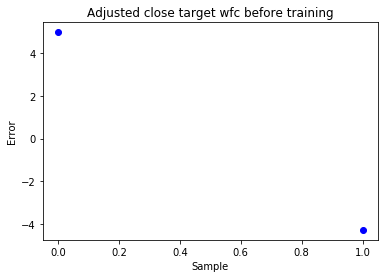

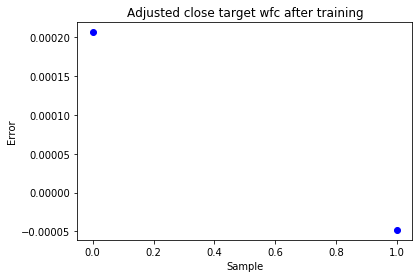


Plotting Each Sample's Time Series


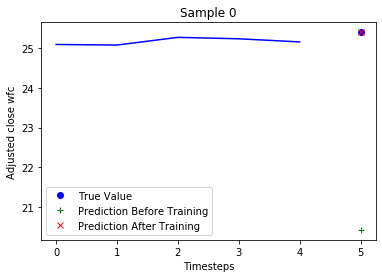

True Target Value: 25.3963
Predicted Target Value Before Training: 20.42641258239746
Predicted Target Value After Training: 25.396093368530273




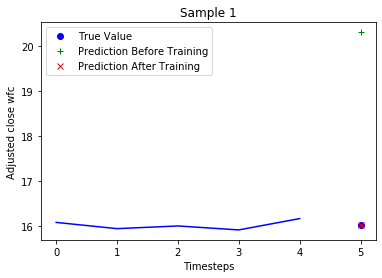

True Target Value: 16.0382
Predicted Target Value Before Training: 20.30572509765625
Predicted Target Value After Training: 16.03824806213379




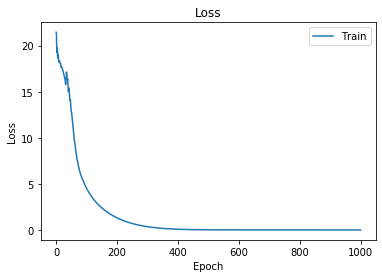

In [5]:
X_small, y_small = sample_dataset(train_dataset, sample_size=2, seed=seed)

del y_small['adjusted_close_target_JPM']
del y_small['adjusted_close_target_BAC']
del y_small['adjusted_close_target_C']

overfit_small_sample(model_text, batch_size=6, epochs=1000, X_small=X_small, y_small=y_small, verbose=1)

From the above plots its clear that our model has overfit on our small sample of the dataset which is the desired behavior.

***

## Evaluating Model:

In this final section we train and evaluate our model architecture using a few different sets of hyperparameters. The metrics we will use to evaluate our model are mean squared error, and accuracy at predict daily stock trends

Restart kernel to clear GPU memory.

In [1]:
# Configuring Virtual GPU and Loading Data

import os
import json
import pickle

from stockanalysis.train import config_hardware

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')

# Random Seed
seed = None

# Configuring GPU and TensorFlow
config_hardware(gpu_memory=7000, seed=seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'val_dataset.pickle'), 'rb') as f:
    val_dataset = pickle.load(f)
    
# Loading Train Dataset's Vocabulary
with open(os.path.join(path_to_data, 'vocab_8k_norm_train_WFC_JPM_BAC_C.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
            
def plot_metric(history, metric):
    name = metric.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(history[metric], label='Train')
    if 'val_' + metric in history:
        ax.plot(history['val_' + metric], linestyle="--", label='Val')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(name)
    ax.set_title(name)
    ax.legend()
    plt.show()
    return None

def print_metric(metrics_values, metric_idx, name):
    if isinstance(metrics_values, list):
        metric_val = metrics_values[metric_idx]
    else: 
        metric_val = metrics_values
    return print(name.format(metric_val))
    
def plot_print_metrics(history, metrics_train, metrics_val, metrics_names):
    for metric_idx, metric_name in enumerate(metrics_names):
        plot_metric(history, metric_name)
        name_train = metric_name.replace('_', ' ').capitalize() + ' on train dataset: {}'
        print_metric(metrics_train, metric_idx, name_train)
        name_val = metric_name.replace('_', ' ').capitalize() + ' on validation dataset: {}'
        print_metric(metrics_val, metric_idx, name_val)
    return None

def plot_print_complete_metrics(model_name, model_version, run_number, metrics_train, metrics_val, metrics_names):
    csvlog = os.path.join('logs', 'models', model_name, '_'.join(['version', str(model_version)]), 'runs', str(run_number), 'history.log')
    df = pd.read_csv(csvfile).drop_duplicates(subset='epoch', keep='last').set_index('epoch')
    plot_print_metrics(df, metrics_train=metrics_train, metrics_val=metrics_val, metrics_names=metrics_names)
    return None

Defining model.

In [3]:
import os
import json
import pickle 
import tensorflow as tf

def embedding_matrix(vocab, init, emb_name):
    '''
    Constructs the embedding matrix for specific init type for a pre-initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = os.path.join('~', '.stockanalysis', 'model_resources', 'glove')
        glove_dir = os.path.expanduser(glove_dir)
        
        try:
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            config_path = os.expanduser(os.path.join('~', '.stockanalysis', 'config.json'))
            with open(config_path, 'r') as f:
                configuration = json.load(f)
            glove_vec_file = os.path.expanduser(configuration['Model_Resources']['glove'])
            # Building word to vector map
            word_embeddings = {}
            with open(glove_vec_file, 'r') as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, emb_name,
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init, emb_name)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab, emb_name, doc_embedding_size):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', emb_name=emb_name, mask_zero=False, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_text(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100, emb_name='current_embedding', 
               output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias = output_bias_init['adjusted_close_target_WFC']
        output_bias_init = tf.keras.initializers.Constant(output_bias)
        
    inputs = {
              'adjusted_close_WFC': tf.keras.Input(shape=(5,), name='adjusted_close_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'adjusted_close_JPM': tf.keras.Input(shape=(5,), name='adjusted_close_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'adjusted_close_BAC': tf.keras.Input(shape=(5,), name='adjusted_close_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'adjusted_close_C': tf.keras.Input(shape=(5,), name='adjusted_close_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64),
             }
    
    doc_embedder = document_embedder_model(vocab, emb_name, doc_embedding_size)
    document_embeddings = [doc_embedder(inputs[fname]) for fname in inputs.keys() if '8-k' in fname]
    
    reshape_doc_embedding = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))
    reshaped_doc_embeddings = [reshape_doc_embedding(doc_embedding) for doc_embedding in document_embeddings]
    
    reshape_price_feature = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))
    reshaped_price_features = [reshape_price_feature(inputs[fname]) for fname in inputs.keys() if '8-k' not in fname]
    time_series_input = tf.keras.layers.Concatenate()(reshaped_doc_embeddings + reshaped_price_features)
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='adjusted_close_target_WFC')
    outputs = {'adjusted_close_target_WFC': output_layer(time_series_lstm)}
    
    
    model = tf.keras.Model(inputs, outputs, name='model_text')
    
    return model

Inspecting both are training and validation datasets.

In [4]:
X_train, y_train = train_dataset
X_val, y_val = val_dataset

print('Feature names and shapes for Training Data:')
for key in X_train:
    print('{}: {}'.format(key, X_train[key].shape[1:]))
print()
print('Feature names and shapes for Validation Data:')
for key in X_val:
    print('{}: {}'.format(key, X_val[key].shape[1:]))
print()
print('Train set size: {}'.format(len(y_train['adjusted_close_target_WFC'])))
print('Validation set size: {}'.format(len(y_val['adjusted_close_target_WFC'])))

Feature names and shapes for Training Data:
adjusted_close_WFC: (5,)
8-k_WFC: (1562,)
adjusted_close_JPM: (5,)
8-k_JPM: (90363,)
adjusted_close_BAC: (5,)
8-k_BAC: (15826,)
adjusted_close_C: (5,)
8-k_C: (53958,)

Feature names and shapes for Validation Data:
adjusted_close_WFC: (5,)
8-k_WFC: (1364,)
adjusted_close_JPM: (5,)
8-k_JPM: (1706,)
adjusted_close_BAC: (5,)
8-k_BAC: (2026,)
adjusted_close_C: (5,)
8-k_C: (2636,)

Train set size: 3014
Validation set size: 1001


Defining model's hyperparameters.

In [5]:
import tensorflow as tf

# Defining Hyperparameters
output_bias_init = {key: y_train[key].mean() for key in y_train}
model_params = {
                'output_bias_init': output_bias_init, 
                'lstm_layer_units': 32
               }
training_params = {
                   'batch_size': 6, 
                   'epochs': 2
                  }
loss = tf.keras.losses.MeanSquaredError
optimizer = tf.keras.optimizers.Adam
optimizer_params = {}

model_version = 0
hyperparameters = {
                   'model_parameters': model_params,
                   'training_parameters': training_params,
                   'loss': loss, 
                   'optimizer': optimizer, 
                   'optimizer_parameters': optimizer_params, 
                   'version': model_version
                  }

# Defining Metrics
metrics = []

# Setting unique Run Number 
run_number = 0

Training model.

In [6]:
from stockanalysis.train import train

model, model_history = train(model_0, hyperparameters, metrics, run_number, X_train, y_train, (X_val, y_val), True, True, True)

Restored model from: logs/models/model_0/version_0/runs/0/checkpoints/cp-1.ckpt
Saved hyperparameters to file: logs/models/model_0/version_0
Train on 3014 samples, validate on 1001 samples
Epoch 1/2
  48/3014 [..............................] - ETA: 29:11 - loss: 4.6273
Epoch 00001: saving model to logs/models/model_0/version_0/runs/0/checkpoints/cp-1.ckpt
  48/3014 [..............................] - ETA: 29:15 - loss: 4.6273

KeyboardInterrupt: 

Evaluating model.

In [ ]:
# Gathering Data

import numpy as np

metrics_train = model.evaluate(X_train, y_train, batch_size=training_params['batch_size'], verbose=0)
metrics_val = model.evaluate(X_val, y_val, batch_size=training_params['batch_size'], verbose=0)
m_preds_train = model.predict(X_train, batch_size=training_params['batch_size'])
m_preds_val = model.predict(X_val, batch_size=training_params['batch_size'])
m_preds_up_train = ((m_preds_train[1:, 0] - y_train['adjusted_close_target_WFC'][:-1]) > 0).astype(int)
m_preds_up_val = ((m_preds_val[1:, 0] - y_val['adjusted_close_target_WFC'][:-1]) > 0).astype(int)
labels_up_train = ((y_train['adjusted_close_target_WFC'][1:] - y_train['adjusted_close_target_WFC'][:-1]) > 0).astype(int)
labels_up_val = ((y_val['adjusted_close_target_WFC'][1:] - y_val['adjusted_close_target_WFC'][:-1]) > 0).astype(int)
up_cls_acc_train = np.mean(np.equal(m_preds_up_train, labels_up_train))
up_cls_acc_val = np.mean(np.equal(m_preds_up_val, labels_up_val))

Learning Curves for Metrics:


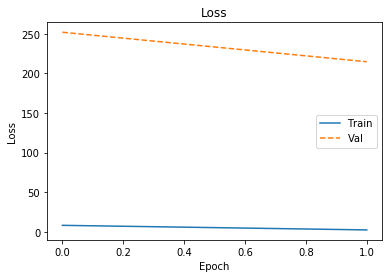

Loss on train dataset: 1.8115987953122437
Loss on validation dataset: 214.70029630479993

Metrics for Classifying Upward Movements
Accuracy on train dataset: 0.9193494855625622
Accuracy on validation dataset: 0.578


In [23]:
# Reporting Data

print('Learning Curves for Metrics:')
plot_print_metrics(model_history.history, metrics_train=metrics_train, metrics_val=metrics_val, metrics_names=model.metrics_names)
print()
print('Metrics for Classifying Upward Movements')
print('Accuracy on train dataset: {}'.format(up_cls_acc_train))
print('Accuracy on validation dataset: {}'.format(up_cls_acc_val))

Complete Learning Curves for Metrics: 


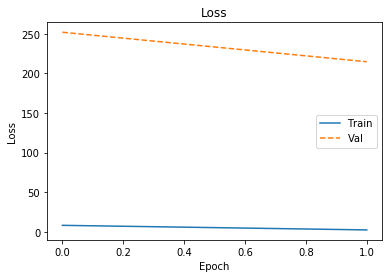

Loss on train dataset: 1.8115987953122437
Loss on validation dataset: 214.70029630479993


In [26]:
print('Complete Learning Curves for Metrics: ')
plot_print_complete_metrics('model_0', model_version, run_number, metrics_train=metrics_train, metrics_val=metrics_val, metrics_names=model.metrics_names)

*(Blah blah blah, talk about experiments)*

***